<a href="https://colab.research.google.com/github/yellowflickerbeat/EXXA_tests/blob/main/2025/gt_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install astropy scikit-learn umap-learn tensorflow tqdm

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

import tensorflow as tf
from tensorflow.keras import layers, models

In [51]:
#Load files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
DATA_PATH = "/content/drive/MyDrive/exxa_25/*.fits"

files = sorted(glob(DATA_PATH))
print("Total files:", len(files))

Total files: 150


In [53]:
images = []

for f in files:
    with fits.open(f) as hdul:
        data = hdul[0].data          # could be (4,600,600) or (1,1,600,600)
        img = np.squeeze(data)[0]    # force → (600,600)
        images.append(img)

images = np.stack(images)
print(images.shape)


(150, 600, 600)


In [54]:
# Normalize (safe)
max_vals = np.max(images, axis=(1,2), keepdims=True)
max_vals[max_vals == 0] = 1.0
images = images / max_vals

# Downsample
images = images[:, ::4, ::4]

# Add channel dim ONCE
images = images[..., np.newaxis]
print(images.shape)

(150, 150, 150, 1)


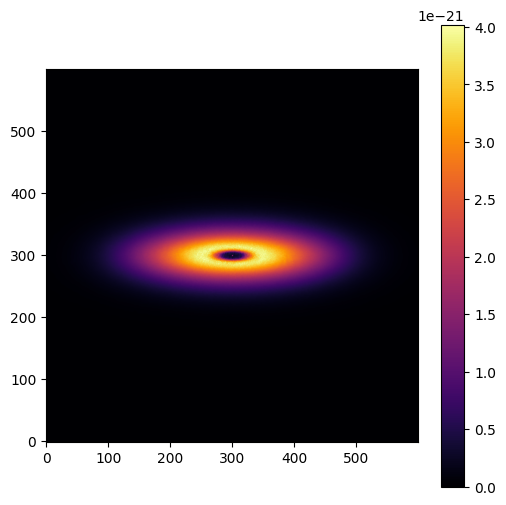

In [55]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Path to ONE fits file
fits_path = "/content/drive/MyDrive/exxa_25/planet86_00414_1250.fits"

# Open and extract image
with fits.open(fits_path) as hdul:
    data = hdul[0].data
    img = np.squeeze(data)[0]   # first physical layer

# Display
plt.figure(figsize=(6,6))
plt.imshow(img, origin="lower", cmap="inferno")
plt.colorbar()
plt.show()

In [56]:
latent_dim = 32

encoder = models.Sequential([
    layers.Input(shape=(150,150,1)),
    layers.Conv2D(16, 3, activation='relu', strides=2, padding='same'),
    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(latent_dim)
])

decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(19*19*64, activation='relu'),
    layers.Reshape((19,19,64)),

    layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),

    #  force exact spatial size
    layers.Cropping2D(((1,1), (1,1))),   # 152 → 150

    layers.Conv2D(1, 3, activation='sigmoid', padding='same')
])

input_img = layers.Input(shape=(150,150,1))

latent = encoder(input_img)
reconstructed = decoder(latent)

autoencoder = models.Model(input_img, reconstructed)


autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │       762,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 150, 150, 1)    │       822,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,585,249 (6.05 MB)

 Trainable params: 1,585,249 (6.05 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
print(images.shape)
assert images.ndim == 4
assert images.shape[-1] == 1
assert not np.isnan(images).any()


(150, 150, 150, 1)


In [58]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

In [59]:
history = autoencoder.fit(
    images, images,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    shuffle=True,
    verbose=1
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.2254 - val_loss: 0.1975
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 988ms/step - loss: 0.2211 - val_loss: 0.1933
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - loss: 0.2157 - val_loss: 0.1868
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 734ms/step - loss: 0.2093 - val_loss: 0.1764
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - loss: 0.1975 - val_loss: 0.1345
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.0910 - val_loss: 0.0198
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step - loss: 0.0128 - val_loss: 0.0198
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 557ms/step - loss: 0.0124 - val_loss: 0.0198
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 613ms/step - loss: 0.0123 - val_loss: 0.0198
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - loss: 0.0122 - val_loss: 0.0198
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 656ms/step - loss: 0.0119 - val_loss: 0.0198
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - loss: 0.0095 - val_los

In [60]:
encoder.trainable = False

In [61]:
latent_vectors = encoder.predict(images)
print(latent_vectors.shape)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(150, 32)


In [62]:
import umap
from sklearn.preprocessing import StandardScaler

latent_scaled = StandardScaler().fit_transform(latent_vectors)

embedding = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
).fit_transform(latent_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [63]:
!pip install hdbscan
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,
    min_samples=4
)
labels = clusterer.fit_predict(embedding)

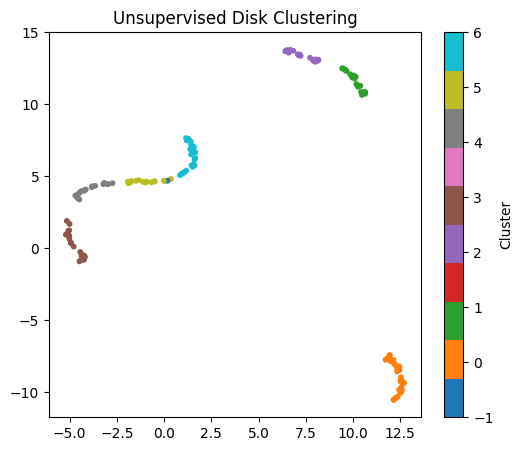

In [64]:
plt.figure(figsize=(6,5))
plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title("Unsupervised Disk Clustering")
plt.show()

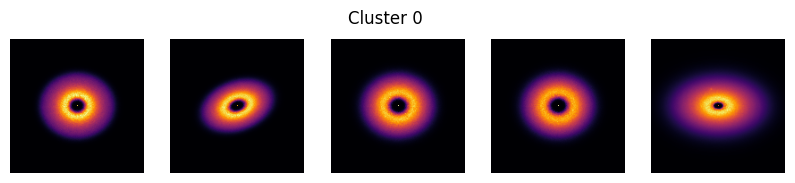

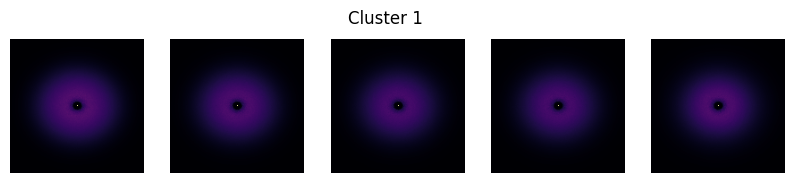

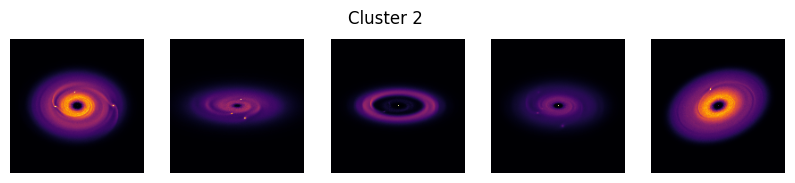

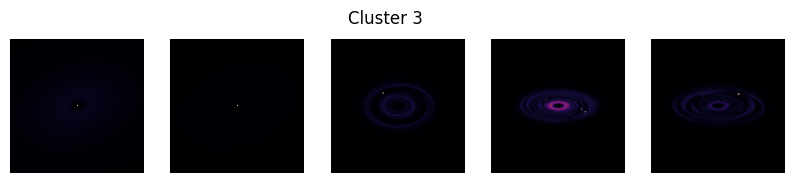

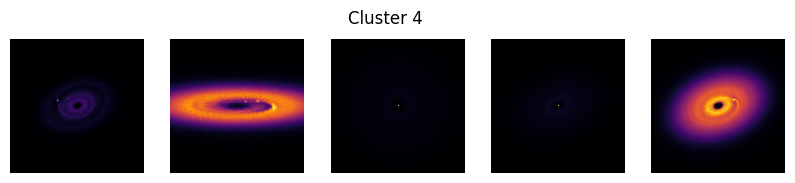

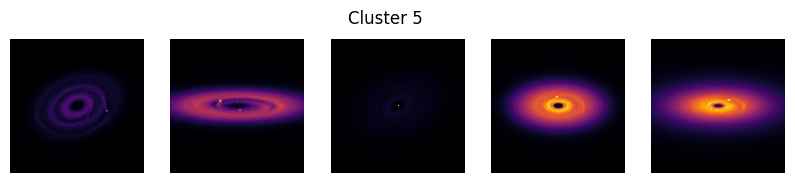

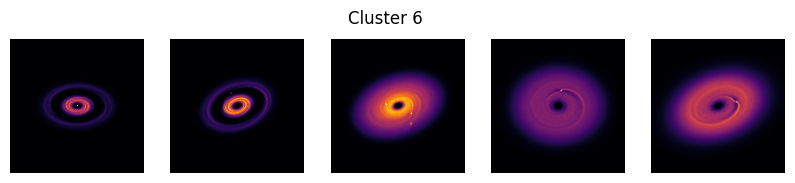

In [65]:
for c in sorted(set(labels) - {-1}):
    idx = np.where(labels == c)[0][:5]
    plt.figure(figsize=(10,2))
    for i,j in enumerate(idx):
        plt.subplot(1,5,i+1)
        plt.imshow(images[j,:,:,0], cmap="inferno", origin="lower")
        plt.axis("off")
    plt.suptitle(f"Cluster {c}")
    plt.show()


In [66]:
# =========================
# EXPERIMENT CONFIGURATION
# =========================

config = {
    "Data": {
        "file_format": "FITS",
        "physical_layer_index": 0,
        "original_resolution": "600 x 600",
        "downsample_factor": 4,
        "final_resolution": "150 x 150",
        "normalization": "Per-image max normalization",
        "channel_dimension": 1
    },

    "Autoencoder_Architecture": {
        "model_type": "CNN Autoencoder",
        "encoder_conv_filters": [16, 32, 64],
        "kernel_size": "3 x 3",
        "stride": 2,
        "latent_dimension": 32,
        "encoder_activation": "ReLU",
        "decoder_type": "Conv2DTranspose",
        "output_activation": "Sigmoid",
        "cropping_layer": "((1,1),(1,1))"
    },

    "Training": {
        "optimizer": "Adam",
        "learning_rate": 1e-3,
        "loss_function": "MSE",
        "epochs": 30,
        "batch_size": 16,
        "validation_split": 0.1,
        "final_validation_loss": 0.019
    },

    "Latent_Space": {
        "feature_dimension": 32,
        "feature_scaling": "StandardScaler"
    },

    "Dimensionality_Reduction": {
        "method": "UMAP",
        "n_neighbors": 15,
        "min_dist": 0.1,
        "output_dimensions": 2
    },

    "Clustering": {
        "algorithm": "HDBSCAN",
        "min_cluster_size": 8,
        "min_samples": 4,
        "outlier_label": -1
    }
}

In [67]:
def print_config_tables(config_dict):
    for section, params in config_dict.items():
        print(f"\n{'='*60}")
        print(f"{section}")
        print(f"{'='*60}")
        for k, v in params.items():
            print(f"{k:30s} : {v}")

print_config_tables(config)


Data
file_format                    : FITS
physical_layer_index           : 0
original_resolution            : 600 x 600
downsample_factor              : 4
final_resolution               : 150 x 150
normalization                  : Per-image max normalization
channel_dimension              : 1

Autoencoder_Architecture
model_type                     : CNN Autoencoder
encoder_conv_filters           : [16, 32, 64]
kernel_size                    : 3 x 3
stride                         : 2
latent_dimension               : 32
encoder_activation             : ReLU
decoder_type                   : Conv2DTranspose
output_activation              : Sigmoid
cropping_layer                 : ((1,1),(1,1))

Training
optimizer                      : Adam
learning_rate                  : 0.001
loss_function                  : MSE
epochs                         : 30
batch_size                     : 16
validation_split               : 0.1
final_validation_loss          : 0.019

Latent_Space
feature_dime